# **Clasificador de Imágenes de rayos X para detección de Neumonía**

---



**Contexto**


El diagnóstico de neumonía a partir de imágenes de rayos X es un desafío crítico en el ámbito médico. Los radiólogos pueden enfrentar dificultades debido a la subjetividad en la interpretación de las imágenes, la variabilidad en la calidad de las radiografías y la necesidad de un diagnóstico rápido y preciso.

Este proyecto busca desarrollar un modelo de clasificación de imágenes que pueda diferenciar entre radiografías con neumonía y radiografías normales. Utilizaremos un conjunto de datos de 5856 imágenes obtenidas de Kaggle, asegurando una distribución equitativa entre las dos clases para el entrenamiento.

Para mejorar la capacidad del modelo y reducir el sobreajuste, aplicaremos técnicas de aumento de datos que ayudarán a mejorar la generalización del modelo en datos no vistos. Además, implementaremos Transfer Learning, reutilizando modelos preentrenados con arquitecturas avanzadas como VGG16, ResNet50 e InceptionV3, que han demostrado un alto rendimiento en tareas de visión por computadora.

Este enfoque permitirá mejorar la precisión del diagnóstico asistido por inteligencia artificial, lo que puede traducirse en detecciones más rápidas y confiables, facilitando la labor de los profesionales de la salud y contribuyendo a la toma de decisiones clínicas más efectivas.

**Objetivos**

Los objetivos de este proyecto son:

Cargar y comprender el conjunto de datos

Etiquetar automáticamente las imágenes

Realizar el aumento de datos

Construir un modelo de clasificación para este problema usando CNN

Mejorar el rendimiento del modelo a través de Transfer Learning, usando VGG16 e InceptionV3.

In [18]:
!pip install tensorflow keras numpy pandas matplotlib kaggle

## **Importación de bibliotecas**

In [26]:
import os
import pickle
import shutil
import random

# Manejo y procesamiento de datos
import numpy as np
import pandas as pd
import seaborn as sns

# Visualización de datos
import matplotlib.pyplot as plt

# Preprocesamiento de imágenes y conjuntos de datos
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# TensorFlow y Keras - Construcción y entrenamiento de modelos
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
)
from tensorflow.keras.backend import clear_session

# Métricas de evaluación
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    f1_score, precision_score, recall_score, cohen_kappa_score
)

# Preparación del conjunto de Datos

In [27]:
def count_images(directory):
    return {category: len(os.listdir(os.path.join(directory, category))) for category in ["NORMAL", "PNEUMONIA"]}

# Descargar y extraer el dataset (Ejecutar en local o en Colab con credenciales de Kaggle)
kaggle_dataset = "paultimothymooney/chest-xray-pneumonia"
!kaggle datasets download -d {kaggle_dataset} --unzip

dataset_path = "chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

print("Dataset inicial:")
print("Train:", count_images(train_dir))
print("Validation:", count_images(val_dir))
print("Test:", count_images(test_dir))

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:21<00:00, 94.2MB/s]
100% 2.29G/2.29G [00:21<00:00, 114MB/s] 
Dataset inicial:
Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation: {'NORMAL': 8, 'PNEUMONIA': 8}
Test: {'NORMAL': 234, 'PNEUMONIA': 390}


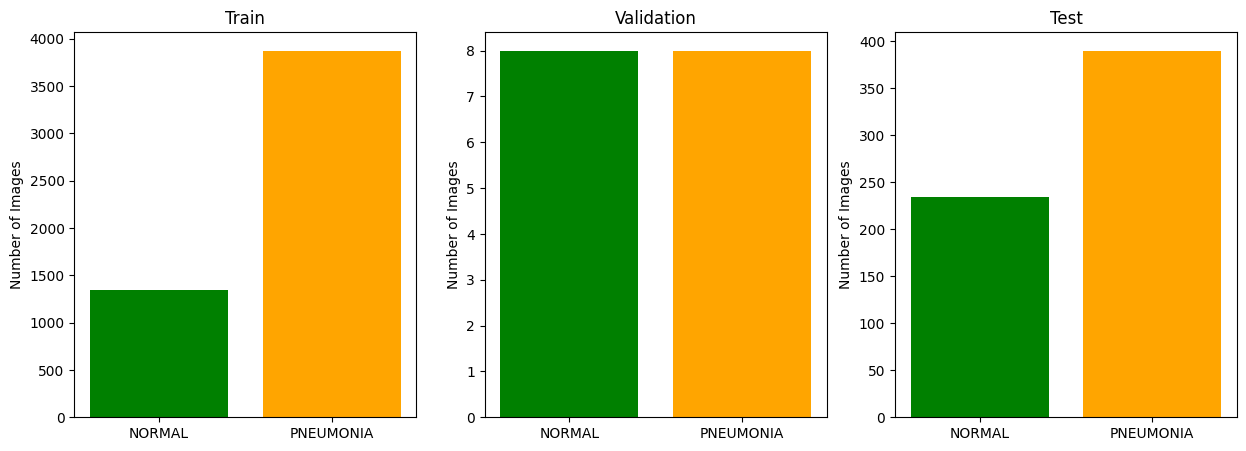

In [28]:
def plot_data_distribution():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    datasets = [train_dir, val_dir, test_dir]
    titles = ["Train", "Validation", "Test"]

    for i, dataset in enumerate(datasets):
        counts = count_images(dataset)  # Usa la función de conteo corregida
        axes[i].bar(["NORMAL", "PNEUMONIA"], [counts["NORMAL"], counts["PNEUMONIA"]], color=["green", "orange"])
        axes[i].set_title(titles[i])
        axes[i].set_ylabel("Number of Images")

    plt.show()

# Ejecutar la nueva función
plot_data_distribution()

Para entrenar nuestro modelo, necesitamos preparar los datos:

Aumento de datos: Aplicar transformaciones para mejorar la generalización.

Normalización: Escalar los valores de los píxeles entre 0 y 1.

Balanceo de clases con oversampling para evitar sesgo en la predicción.

Distribución 80-10-10 asegurando suficientes datos para cada fase.

In [58]:
img_size = (256, 256)
batch_size = 32

train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

# Conjunto de entrenamiento (80% de train)
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.2,  # Separamos 20% para validación
    subset="training",
    seed=417
)

# Conjunto de validación (20% de train)
validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.2,
    subset="validation",
    seed=417
)

# Conjunto de prueba
test_set = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size
)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [59]:
# Datos de entrenamiento (Train)
train_class_counts = {0: 1095, 1: 3078}  # Cantidad de imágenes por clase

# Calcular pesos de clase
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),  # 0 = NORMAL, 1 = PNEUMONIA
    y=np.concatenate([np.full(train_class_counts[0], 0), np.full(train_class_counts[1], 1)])
)

# Convertir a diccionario
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Pesos de clase:", class_weights_dict)

Pesos de clase: {0: 1.9054794520547946, 1: 0.6778752436647173}


## **Visualización de algunas imágenes**

Antes de seguir adelante y realizar el aumento de datos, revisamos aleatoriamente algunas de las imágenes:

<ipython-input-60-af3de1b3556c>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i].set_title(train_set.class_names[int(label)])


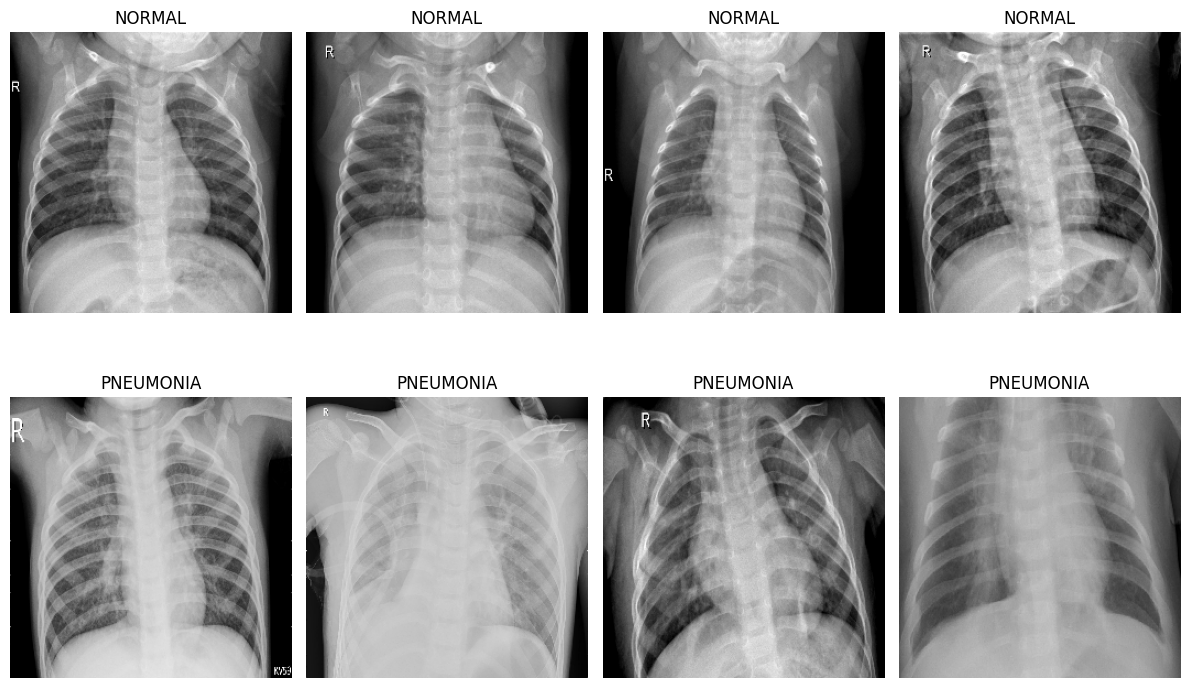

\Cada imagen tiene la forma (256, 256, 3)


In [60]:
# Obtener una selección de imágenes y etiquetas del conjunto de entrenamiento
images, labels = next(iter(train_set.take(1)))

# Convertir las imágenes y etiquetas a matrices NumPy
images = images.numpy()
labels = labels.numpy()

# Ordenar los pares imagen-etiqueta en función de la etiqueta (orden ascendente)
sorted_pairs = sorted(zip(images, labels), key=lambda x: x[1])

# Seleccionar una muestra de imágenes con etiquetas tanto de "normal" como de "neumonía"
sample = sorted_pairs[:4] + sorted_pairs[-4:]

# Graficar las imágenes ordenadas con sus etiquetas correspondientes
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
axes = axes.flatten()

# Formatear la gráfica
for i, (image, label) in enumerate(sample):
    axes[i].imshow(image.astype("uint8"))
    axes[i].set_title(train_set.class_names[int(label)])
    axes[i].axis("off")
plt.tight_layout()

# Mostrar la gráfica
plt.show()
print(f'\Cada imagen tiene la forma {sample[0][0].shape}')

Las imágenes tienen 3 canales, a pesar de que parecen estar en escala de grises. Todas las radiografías tienen el lado derecho del paciente (la "R" blanca en la imagen) en el lado IZQUIERDO de la imagen, esto parece ser consistente en todo el conjunto de datos.

Dado que los humanos no somos perfectamente simétricos (por ejemplo, nuestro corazón está en nuestro lado izquierdo), no sería conveniente voltear ninguna imagen horizontalmente con ello se preservará la "lateralidad" de las radiografías en caso de que eso afecte el diagnóstico.

Hay una pequeña cantidad de rotación en las radiografías. Presumiblemente, esto se produce cuando las toman. Podríamos sacar provecho de esto si añadiéramos un aumento rotacional a nuestro conjunto de entrenamiento, lo que aumentará la varianza sin perder "lateralidad".

## **Entrenamiento y Gestión de Modelos**

Se implementa las funciones para entrenar, evaluar y gestionar los modelos de aprendizaje profundo en TensorFlow. Primero, definimos la función plot_history, que grafica la precisión y la pérdida del modelo en función de las épocas, permitiendo analizar su rendimiento durante el entrenamiento. Luego, configuramos una estrategia de Early Stopping para detener el entrenamiento si la precisión en validación deja de mejorar, evitando el sobreajuste. Finalmente, la función fit_plot_store entrena el modelo desde cero o carga el modelo previamente entrenado si existe, se almacena su historial de entrenamiento, guarda los pesos del modelo y registra métricas clave, asegurando un manejo eficiente y organizado del proceso de entrenamiento.

In [61]:
# Función para graficar la historia del entrenamiento
def plot_history(history):
    """
    Grafica la precisión y la pérdida del modelo en cada época para entrenamiento y validación.

    Parámetros:
        history (dict): Diccionario con el historial de entrenamiento.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for metric, ax in zip(['accuracy', 'loss'], axs):
        epochs = len(history[metric]) + 1  # Ajusta el número de épocas
        ax.plot(np.arange(1, epochs), history[metric])
        ax.plot(np.arange(1, epochs), history['val_' + metric])
        ax.set_title(f'Model {metric.capitalize()}')
        ax.set_ylabel(metric.capitalize())
        ax.set_xlabel('Época')
        ax.legend(['Entrenamiento', 'Validación'], loc='upper left')
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

# Callback para detener el entrenamiento si no mejora después de 3 épocas
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# Listas para almacenar información de modelos entrenados
model_info = []
model_list = []

# Obtener etiquetas reales del dataset de entrenamiento
y_train = np.concatenate([y.numpy() for _, y in train_set])

# Función para entrenar, graficar y almacenar modelos
def fit_plot_store(model, epochs=10, shuffle=False, overwrite=False):
    """
    Entrena el modelo, grafica el historial de entrenamiento y almacena los resultados.

    Parámetros:
        model (tf.keras.Model): Modelo a entrenar.
        epochs (int, opcional): Número de épocas (por defecto 10).
        shuffle (bool, opcional): Si se deben reorganizar los datos en cada época (por defecto False).
        overwrite (bool, opcional): Si se deben sobrescribir modelos ya existentes (por defecto False).

    Retorna:
        None
    """
    # Definir nombres de archivos y carpetas
    model_name = model.name
    directories = ['models', 'history']
    model_file = f'models/{model_name}.h5'  # Guarda en formato .h5
    history_file = f'history/{model_name}_history.pkl'

    # Verificar si el modelo y el historial ya existen
    if os.path.exists(model_file) and os.path.exists(history_file) and not overwrite:
        # Cargar modelo e historial existente
        model = load_model(model_file)
        with open(history_file, 'rb') as file:
            history = pickle.load(file)
        print(f'Modelo "{model_name}" cargado desde el disco.')
    else:
        # Entrenar modelo con class weights
        history = model.fit(
            train_set,
            epochs=epochs,
            validation_data=validation_set,
            shuffle=shuffle,
            callbacks=[callback],
            class_weight=class_weights_dict  # Se agregan los pesos de clase
        ).history

        # Crear directorios si no existen
        for dir in directories:
            os.makedirs(dir, exist_ok=True)

        # Guardar modelo en formato .h5
        model.save(model_file)
        with open(history_file, 'wb') as file:
            pickle.dump(history, file)

        print(f'Modelo "{model_name}" guardado en {model_file} (formato .h5)')

    # Graficar historial de entrenamiento
    plot_history(history)

    # Extraer métricas del entrenamiento
    training_accuracy = history['accuracy'][-1]
    val_accuracy = history['val_accuracy'][-1]
    training_loss = history['loss'][-1]
    val_loss = history['val_loss'][-1]
    trainable_params = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    num_epochs = len(history['accuracy'])
    total_params = trainable_params + non_trainable_params

    # Almacenar información del modelo
    model_info.append([
        model_name, training_accuracy, val_accuracy, training_loss,
        val_loss, trainable_params, non_trainable_params, total_params, num_epochs
    ])
    model_list.append(model)

    # Guardar métricas en CSV para comparaciones futuras
    df_metrics = pd.DataFrame(model_info, columns=[
        "Modelo", "Precisión Entrenamiento", "Precisión Validación",
        "Pérdida Entrenamiento", "Pérdida Validación",
        "Parámetros Entrenables", "Parámetros No Entrenables",
        "Parámetros Totales", "Épocas"
    ])
    df_metrics.to_csv("model_metrics.csv", index=False)
    print(df_metrics)

    # Mostrar la mejor val_accuracy lograda
    best_val_acc = max(history['val_accuracy'])
    print(f"\nMejor precisión en validación alcanzada: {best_val_acc:.4f}")

# Función para evaluar el modelo en el conjunto de prueba
def evaluate_model(model, test_set):
    """
    Evalúa el modelo en el conjunto de prueba y muestra el reporte de clasificación.

    Parámetros:
        model (tf.keras.Model): Modelo entrenado.
        test_set (tf.data.Dataset): Conjunto de prueba.

    Retorna:
        None
    """
    y_true = np.concatenate([y.numpy() for _, y in test_set])  # Etiquetas reales
    y_pred = np.argmax(model.predict(test_set), axis=1)  # Predicciones

    print("\nReporte de Clasificación en Test Set:")
    print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))



El siguiente código se usa para asegurarnos de que los modelos y datos de entrenamiento estén disponibles sin necesidad de descargar todo el repositorio

In [62]:
# Definir los directorios a verificar y la URL del repositorio
directories = ["models", "history"]
repo_url = "https://github.com/Yoseph10/chest_xray_pneumonia.git"
directories_to_download = []

# Verificar si los directorios existen y agregarlos a la lista de descarga si no existen
for dir in directories:
    if not os.path.exists(dir):
        directories_to_download.append(dir)

# Realizar la descarga mediante sparse checkout si hay directorios que faltan
if directories_to_download:
    if not os.path.exists('.git'):
        !git init  # Inicializar repositorio Git
        !git config --global init.defaultBranch main  # Definir rama principal
        !git config core.sparseCheckout true  # Habilitar descarga parcial
        !git remote add -f origin {repo_url}  # Agregar repositorio remoto

    # Escribir en el archivo sparse-checkout los directorios a descargar
    with open('.git/info/sparse-checkout', 'w') as file:
        for dir in directories_to_download:
            file.write(f'{dir}/\n')

    !git pull origin master  # Descargar los archivos necesarios

    # Extraer archivos ZIP dentro de los directorios descargados
    for dir in directories_to_download:
        for root, dirs, files in os.walk(dir):
            for file in files:
                if file.endswith(".zip"):
                    zip_path = os.path.join(root, file)
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(root)  # Extraer contenido del ZIP
                    print(f"Archivo extraído: {zip_path}")
else:
    print("Los directorios no fueron descargados porque ya existen localmente.")


Los directorios no fueron descargados porque ya existen localmente.


## **Modelo CNN**

<div> Con el siguiente código se define y compila el modelo CNN simple para la clasificación binaria de las imágenes. Normalizamos las imágenes, aplicamos una capa convolucional con MaxPooling, aplanamiento y dos capas densas, finalizando con activación sigmoide. Se compila con Adam y binary crossentropy para optimizar la precisión.<div>

In [63]:
model_CNN_1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name='Model_CNN_1')

model_CNN_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_CNN_1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Model_CNN_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │       1,048,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,048,817 (4.00 MB)

 Trainable params: 1,048,817 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 676ms/step - accuracy: 0.4789 - loss: 0.6725 - val_accuracy: 0.8725 - val_loss: 0.6037
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 152s 755ms/step - accuracy: 0.8810 - loss: 0.4349 - val_accuracy: 0.8130 - val_loss: 0.6485
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 799ms/step - accuracy: 0.9220 - loss: 0.3868 - val_accuracy: 0.8830 - val_loss: 0.5239
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 114s 858ms/step - accuracy: 0.9405 - loss: 0.3329 - val_accuracy: 0.8121 - val_loss: 0.6127
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 709ms/step - accuracy: 0.9259 - loss: 0.4119 - val_accuracy: 0.9463 - val_loss: 0.4109
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 664ms/step - accuracy: 0.9643 - loss: 0.2662 - val_accuracy: 0.9626 - val_loss: 0.3591
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 146s 697ms/step - accuracy: 0.9693 - loss: 0.2418 - val_accuracy: 0.9511 - val_loss: 0.3606
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 153s 786ms/step - accuracy: 0.9741 - lo

Modelo "Model_CNN_1" guardado en models/Model_CNN_1.h5 (formato .h5)


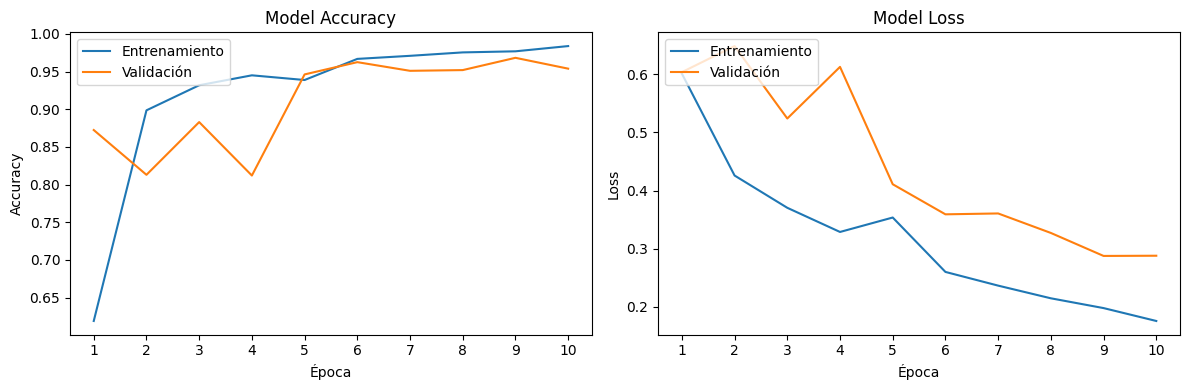

        Modelo  Precisión Entrenamiento  Precisión Validación  \
0  Model_CNN_1                 0.983944              0.953979   

   Pérdida Entrenamiento  Pérdida Validación  Parámetros Entrenables  \
0               0.175667            0.287902                 1048817   

   Parámetros No Entrenables  Parámetros Totales  Épocas  
0                        0.0           1048817.0      10  

Mejor precisión en validación alcanzada: 0.9684


In [64]:
fit_plot_store(model_CNN_1)

In [66]:
# Guardar el modelo CNN
model_CNN_1.save('model_CNN_1.h5')

In [68]:
from google.colab import files

# Descargar el archivo guardado del modelo
files.download('models/Model_CNN_1.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Vamos a agregar otra capa convolucional y una capa de max pooling. La capa Conv2D va a agregar otro conjunto de filtros, que luego se simplificarán aún más con MaxPooling2D. Por lo tanto, este modelo debería ser mucho más pequeño que model_CNN_1.

In [70]:
model_CNN_2 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_CNN_2'
    )

model_CNN_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_CNN_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Model_CNN_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 8)         │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │         262,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,769 (1.01 MB)

 Trainable params: 263,769 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Se han agregado dos capas y reducido 4 veces el número de parámetros.

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6372 - loss: 0.5399 - val_accuracy: 0.9012 - val_loss: 0.2707
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9572 - loss: 0.1319 - val_accuracy: 0.9559 - val_loss: 0.1048
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 980ms/step - accuracy: 0.9581 - loss: 0.1102 - val_accuracy: 0.9616 - val_loss: 0.0931
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9701 - loss: 0.0757 - val_accuracy: 0.9645 - val_loss: 0.0902
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 979ms/step - accuracy: 0.9744 - loss: 0.0618 - val_accuracy: 0.9712 - val_loss: 0.0841
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9840 - loss: 0.0488 - val_accuracy: 0.9319 - val_loss: 0.2152
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9783 - loss: 0.0541 - val_accuracy: 0.9703 - val_loss: 0.0819
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9895 - loss: 0.0284 - va

Modelo "Model_CNN_2" guardado en models/Model_CNN_2.h5 (formato .h5)


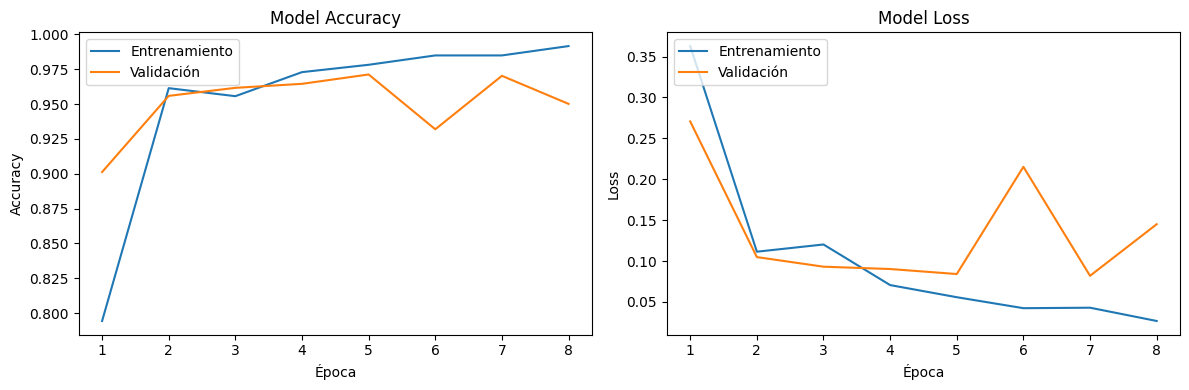

        Modelo  Precisión Entrenamiento  Precisión Validación  \
0  Model_CNN_1                 0.983944              0.953979   
1  Model_CNN_2                 0.991613              0.950144   

   Pérdida Entrenamiento  Pérdida Validación  Parámetros Entrenables  \
0               0.175667            0.287902                 1048817   
1               0.026688            0.144996                  263769   

   Parámetros No Entrenables  Parámetros Totales  Épocas  
0                        0.0           1048817.0      10  
1                        0.0            263769.0       8  

Mejor precisión en validación alcanzada: 0.9712


In [71]:
fit_plot_store(model_CNN_2)

In [77]:
# Guardar el modelo CNN
model_cnn_2.save('model_cnn_2.h5')

In [79]:
# Descargar el archivo guardado del modelo
files.download('models/model_cnn_2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nuestro modelo 1 (model_cnn_1) tiene una precisión de validación ligeramente mejor (0.9684) en comparación con model_cnn_2.

Sin embargo, model_cnn_2 tiene una pérdida de validación menor (0.144996 vs. 0.287902) y utiliza significativamente menos parámetros entrenables (263769 vs. 1048817).

A continuación se genera un tercer modelo con rotación aleatoria de las imágenes de hasta 15 grados para evitar que memorice orientaciones específicas. Adicionalmente se cambia el orden de las imágenes para evitar que aprenda la secuencia.

In [82]:
from tensorflow.keras import layers, models

model_cnn_3 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.RandomRotation(0.15),  # Cambiar 15 a 0.15 para que esté en el rango correcto
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='Model_CNN_3')

model_cnn_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_cnn_3.summary()

Model: "Model_CNN_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 8)         │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │         262,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,769 (1.01 MB)

 Trainable params: 263,769 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.4702 - loss: 0.7133 - val_accuracy: 0.7641 - val_loss: 0.6910
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.5417 - loss: 0.7033 - val_accuracy: 0.7641 - val_loss: 0.6917
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5546 - loss: 0.7044 - val_accuracy: 0.7641 - val_loss: 0.6915
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.4100 - loss: 0.7053 - val_accuracy: 0.7641 - val_loss: 0.6920
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Modelo "Model_CNN_3" guardado en models/Model_CNN_3.h5 (formato .h5)


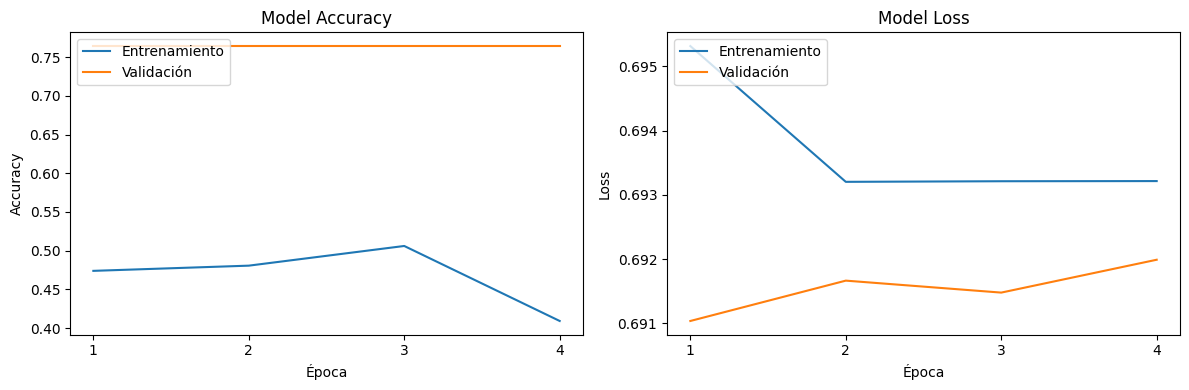

        Modelo  Precisión Entrenamiento  Precisión Validación  \
0  Model_CNN_1                 0.983944              0.953979   
1  Model_CNN_2                 0.991613              0.950144   
2  Model_CNN_3                 0.409298              0.764142   

   Pérdida Entrenamiento  Pérdida Validación  Parámetros Entrenables  \
0               0.175667            0.287902                 1048817   
1               0.026688            0.144996                  263769   
2               0.693214            0.691989                  263769   

   Parámetros No Entrenables  Parámetros Totales  Épocas  
0                        0.0           1048817.0      10  
1                        0.0            263769.0       8  
2                        0.0            263769.0       4  

Mejor precisión en validación alcanzada: 0.7641


In [83]:
fit_plot_store(model_cnn_3, epochs=20, shuffle=True)

In [85]:
# Guardar el modelo CNN
model_cnn_3.save('model_CNN_3.h5')

In [86]:
# Descargar el archivo guardado del modelo
files.download('models/Model_CNN_3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

El modelo 3 (Model_CNN_3) muestra una precisión de validación inferior y una pérdida de validación más alta, lo que sugiere que el modelo no ha generalizado bien a partir del conjunto de entrenamiento.

**Conclusión:** Nuestro modelo 1 (Model_CNN_1) tiene una mejor precisión en validación, pero nuestro modelo 2 (Model_CNN_2) muestra una pérdida menor y es más eficiente en términos de parámetros entrenables, reduciéndolos 4 veces. El modelo 3 requiere más ajustes.

# **Transfer Learning**

La transferencia de aprendizaje mejora significativamente la eficiencia y efectividad de las redes neuronales, incluidas las CNN, utilizando el conocimiento de modelos previamente entrenados. Sus beneficios incluyen:

Convergencia Rápida: Acelera el entrenamiento al partir de patrones ya aprendidos.

Menor Requisito de Datos: Útil cuando el conjunto de datos es pequeño, aprovechando características preaprendidas.

Mejor Rendimiento: Mayor precisión y generalización en nuevas tareas al construir sobre bases existentes.

Eficiencia y Adaptabilidad: Uso eficiente de recursos y facilidad para adaptar modelos a problemas relacionados.

Aplicación
Usaremos una variante de ResNet, un modelo entrenado con el conjunto de datos ImageNet.

In [88]:
from tensorflow.keras import applications

In [89]:
# Construir un modelo ResNet50
resnet50_base = applications.ResNet50(
    weights='imagenet',        # Usar pesos preentrenados de ImageNet
    include_top=False,         # No incluir las capas superiores (cabeza) del modelo preentrenado
    pooling='max',             # Usar pooling máximo para las salidas de la última capa convolucional
    input_shape=(img_size[0], img_size[1], 3)  # Definir la forma de entrada de las imágenes
)

# Congelar el modelo ResNet50
resnet50_base.trainable = False  # Hacer que las capas de ResNet50 no sean entrenables

# Agregar una capa densa
resnet50 = models.Sequential([
    resnet50_base,                  # Añadir la base del modelo ResNet50 congelada
    layers.Dense(1, activation='sigmoid')  # Añadir una capa densa con activación sigmoide
    ],
    name='ResNet50'                 # Nombrar el modelo como 'ResNet50'
)

# Compilar el modelo
resnet50.compile(
    optimizer='adam',               # Usar el optimizador Adam
    loss='binary_crossentropy',     # Usar la función de pérdida de entropía cruzada binaria
    metrics=['accuracy']            # Evaluar el modelo con la métrica de precisión
)

# Mostrar un resumen del modelo
resnet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Para nuestro modelo de 23.5 millones de parámetros, solo estamos entrenando 2049 parámetros.

Antes de ajustar nuestro modelo, es necesario preprocesar las imágenes. ResNet50 tiene expectativas específicas para las imágenes. Según la documentación: > Las imágenes se convierten de RGB a BGR, y luego cada canal de color se centra en cero con respecto al conjunto de datos ImageNet, sin escalado.

Se están ajustando los rangos y el orden de los píxeles. La información subyacente sigue siendo la misma, por lo que podemos comparar directamente los resultados de ResNet con los modelos creados manualmente.

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 867s 7s/step - accuracy: 0.7878 - loss: 0.7756 - val_accuracy: 0.9406 - val_loss: 0.2210
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 895s 6s/step - accuracy: 0.9414 - loss: 0.1951 - val_accuracy: 0.9348 - val_loss: 0.2266
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 809s 6s/step - accuracy: 0.9551 - loss: 0.1146 - val_accuracy: 0.9540 - val_loss: 0.1499
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 829s 6s/step - accuracy: 0.9697 - loss: 0.0967 - val_accuracy: 0.9549 - val_loss: 0.1465
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 784s 6s/step - accuracy: 0.9778 - loss: 0.0582 - val_accuracy: 0.9645 - val_loss: 0.1263
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 783s 6s/step - accuracy: 0.9798 - loss: 0.0484 - val_accuracy: 0.9195 - val_loss: 0.3260
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 843s 6s/step - accuracy: 0.9807 - loss: 0.0540 - val_accuracy: 0.9664 - val_loss: 0.1161
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 861s 6s/step - accuracy: 0.9863 - loss: 0.0322 - val_accu

Modelo "ResNet50" guardado en models/ResNet50.h5 (formato .h5)


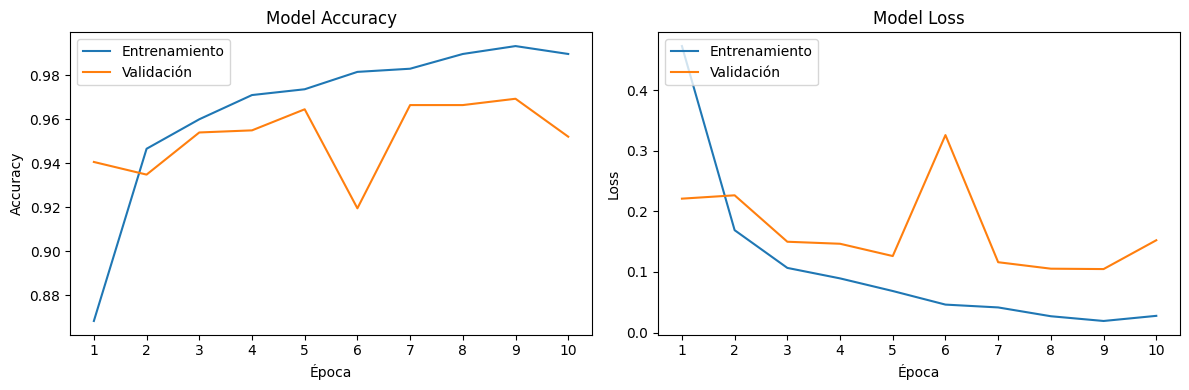

        Modelo  Precisión Entrenamiento  Precisión Validación  \
0  Model_CNN_1                 0.983944              0.953979   
1  Model_CNN_2                 0.991613              0.950144   
2  Model_CNN_3                 0.409298              0.764142   
3     ResNet50                 0.989696              0.952061   

   Pérdida Entrenamiento  Pérdida Validación  Parámetros Entrenables  \
0               0.175667            0.287902                 1048817   
1               0.026688            0.144996                  263769   
2               0.693214            0.691989                  263769   
3               0.027514            0.152348                    2049   

   Parámetros No Entrenables  Parámetros Totales  Épocas  
0                        0.0           1048817.0      10  
1                        0.0            263769.0       8  
2                        0.0            263769.0       4  
3                 23587712.0          23589761.0      10  

Mejor precisión e

In [90]:
# Define the preprocessing function
def preprocess_image(image, label):
    image = applications.resnet.preprocess_input(image)
    return image, label

# Apply necessary preprocessing using tf.data.Dataset.map()
resnet_train = train_set.map(preprocess_image)
resnet_val = validation_set.map(preprocess_image)
resnet_test = test_set.map(preprocess_image)

# Train the model
fit_plot_store(resnet50)

In [97]:
# Guardar el modelo CNN
resnet50.save('model_resnet50_1.h5')

In [99]:
# Descargar el archivo guardado del modelo
files.download('model_resnet50_1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Se va a generar un segundo modelo ResNet dejando activado "shuffle" con el fin de evitar que el modelo aprenda la secuencia de imágenes, adicionalmente se agrega Dropout de 0.3 para prevenir el sobreajuste al "desactivar" aleatoriamente una proporción de neuronas durante el entrenamiento.

In [ ]:
# Add a dense layer and dropout
resnet50_2 = models.Sequential([
    resnet50_base,
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50_2'
    )

# Compile the model
resnet50_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50_2.summary()

# **Modelo VGG-16**

Ahora, usando la idea de Transfer Learning. Cargaremos una arquitectura preconstruida: VGG16, que se entrenó en el conjunto de datos de ImageNet.

En el entrenamiento de este modelo, se congela las capas iniciales y se ajustan solo las últimas 6, se agregan capas densas con regularización y normalización para mejorar generalización y se excluye la parte superior del modelo, es decir, las capas densas que originalmente clasificaban en 1000 clases.

In [ ]:
# Cargar VGG16 como modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers[:-6]:
    layer.trainable = False

# Modelo Individual
input_layer = Input(shape=(150, 150, 3))
x = base_model(input_layer, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
output_layer = Dense(1, activation='sigmoid', activity_regularizer=l2(0.001))(x)
model_vgg16 = Model(inputs=input_layer, outputs=output_layer)

# Compilación
model_vgg16.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# **InceptionV3 Model**

El modelo toma las imágenes de entrada (preprocesadas y escaladas), extrae características usando InceptionV3 y, con una capa final personalizada, hace una predicción binaria. En el entrenamiento de este modelo se redimensiona imágenes a 299x299 para ser compatibles.

In [ ]:
# Configuración de los generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    './resampled_dataset/train',
    target_size=(299, 299),  # Tamaño de imagen esperado por InceptionV3
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    './resampled_dataset/val',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    './resampled_dataset/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Comparación de Modelos

A continuacion comparamos las caracteristicas más relevantes de los modelos ya entrenados.

In [ ]:
column_names = ['Model Name', 'Training Accuracy', 'Validation Accuracy',
                'Training Loss', 'Validation Loss', 'Trainable Parameters',
                'Non-trainable Parameters', 'Total Parameters',
                'Number of Epochs']


# Changes the list to a DataFrame
model_info_df = pd.DataFrame(model_info, columns=column_names)
model_info_df.set_index('Model Name', inplace=True)

# Sort the DataFrame by Model Name
model_info_df.sort_values('Model Name', inplace=True)
model_info_df

Definimos una función para compara graficamente la precisión de entrenamiento y validación

In [ ]:
def plot_accuracy(df, vars, subtitle=''):
    '''Dibuja las precisiones especificadas (vars) para cada modelo en df'''
    # Reformatear los datos de formato ancho a largo
    melted_df = df.reset_index().melt(id_vars='Model Name',
                                      value_vars=vars,
                                      var_name='Metric',
                                      value_name='Accuracy')

    # Graficar el diagrama de barras verticales usando Seaborn
    plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura
    ax = sns.barplot(x='Model Name', y='Accuracy',
                     hue='Metric', data=melted_df, errorbar=None)


    # Establecer el título y las etiquetas de los ejes
    plt.title('Precisión por Modelo' + subtitle)
    plt.xlabel('Nombre del Modelo')
    plt.ylabel('Precisión')
    plt.ylim(0.6, 1)  # Establece el rango de la precisión
    plt.tight_layout()  # Ajusta el espaciado

    # Añadir etiquetas de valor a las barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3g', label_type='edge',
                     padding=-13, color='white'
                     )

    # Mover la leyenda a la derecha del gráfico
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Métrica')


    # Mostrar el gráfico
    plt.show()

# Uso
plot_accuracy(model_info_df,
              ['Training Accuracy', 'Validation Accuracy']
              )
